# Model Simplification and Analysis

# Introduction

The objective of this analysis was to explore the dataset provided, identify the most parsimonious model, and evaluate the predictive performance of various models, including:

Ordinary Least Squares (OLS) Regression

Generalized Linear Model (GLM)

Mixed Effects Model

This report outlines the steps taken, results obtained, and the conclusion on the most parsimonious model.

# Dataset Summary

The dataset was examined for its structure, including column types, missing values, and basic statistics. Key observations included:

The dataset contains both numeric and categorical variables.

"Score" was identified as the target variable.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

In [3]:
data = pd.read_csv("2018.csv")

In [5]:
print("Dataset Info:")
data.info()
print("\nSummary Statistics:\n", data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB

Summary Statistics:
        Overall rank       Score  GDP per capita  Social support  \
count    156.000000  156.000000      156.000000      156.000000   
mean      78.5

In [7]:
def plot_correlation_heatmap(data):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()


In [9]:
def plot_boxplots(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=data[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

# Correlation Heatmap:

Highlighted relationships between numeric predictors and the target variable.

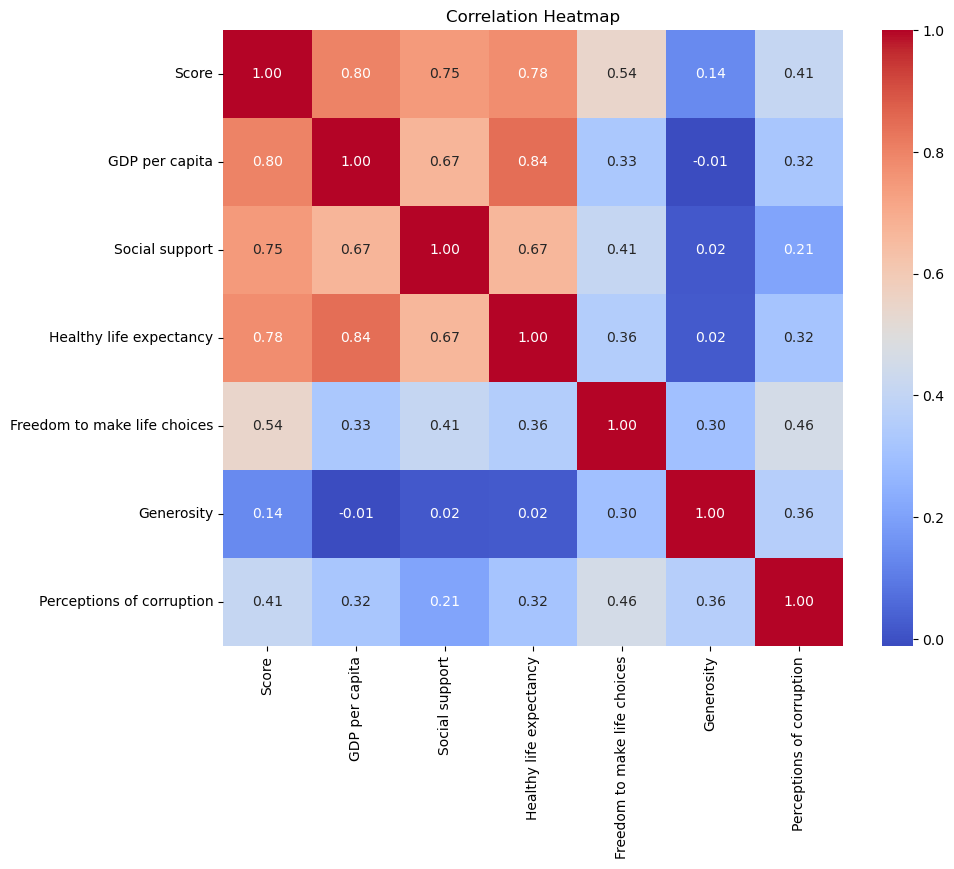

In [11]:
plot_correlation_heatmap(data.drop(columns=['Overall rank', 'Country or region']))

# Boxplots:

Identified potential outliers and distribution patterns of variables.



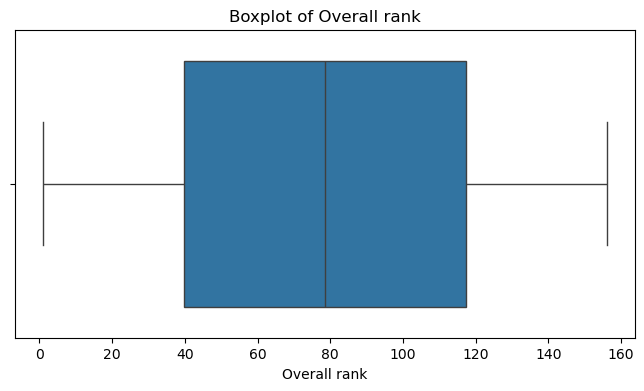

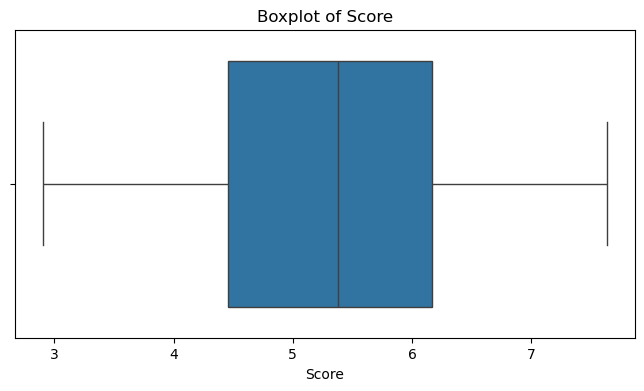

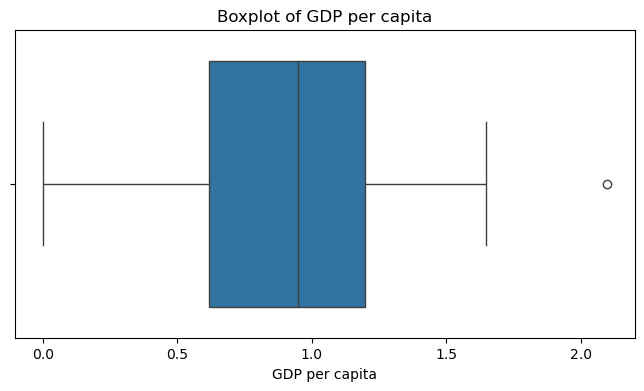

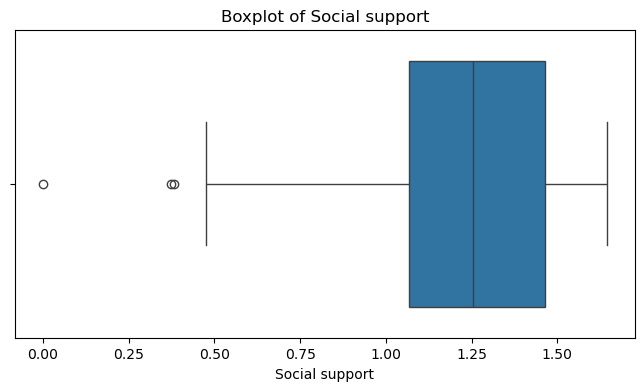

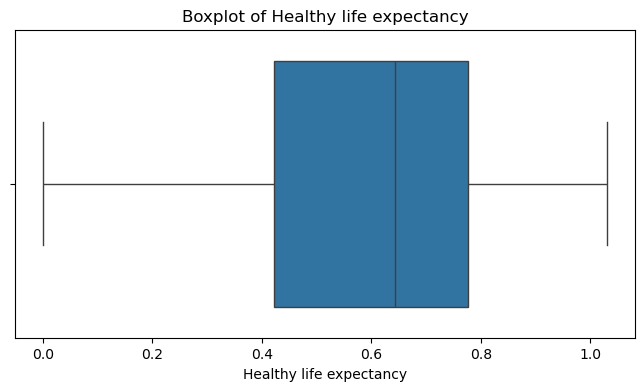

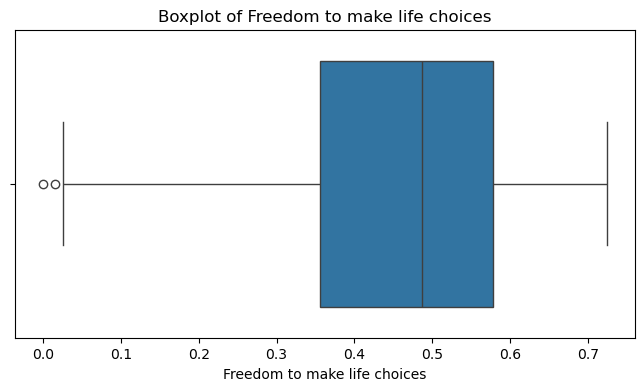

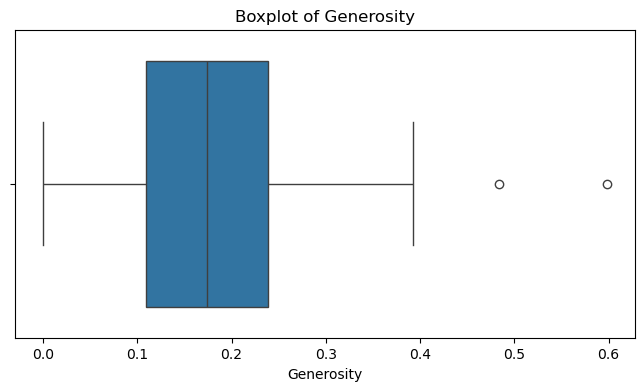

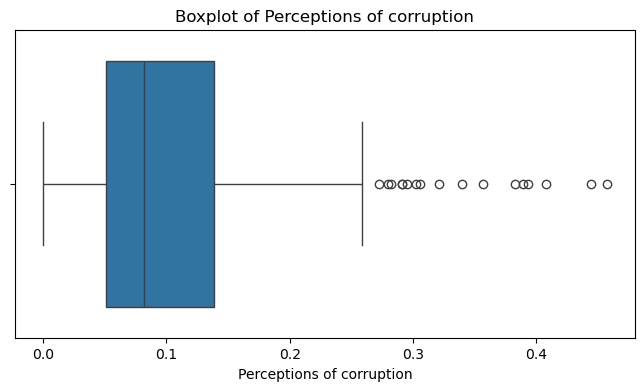

In [13]:
plot_boxplots(data)


In [15]:
target = 'Score'
features = [col for col in data.columns if col not in ['Overall rank', 'Country or region', target]]

X = data[features]
y = data[target]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

LinearRegression()

In [23]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"R-squared: {r2:.3f}")

Train RMSE: 0.501
Test RMSE: 0.563
R-squared: 0.694


In [25]:
X_train_sm = sm.add_constant(X_train)  # Add intercept for statsmodels
ols_model = sm.OLS(y_train, X_train_sm).fit()

print("\nOLS Model Summary:")
print(ols_model.summary())


OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     81.19
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           2.32e-39
Time:                        22:58:15   Log-Likelihood:                -90.353
No. Observations:                 124   AIC:                             194.7
Df Residuals:                     117   BIC:                             214.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [27]:
significant_features = features.copy()
while True:
    X_train_sm = sm.add_constant(X_train[significant_features])
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    p_values = ols_model.pvalues.drop('const')
    max_pval = p_values.max()
    
    if max_pval > 0.05:
        feature_to_drop = p_values.idxmax()
        significant_features.remove(feature_to_drop)
        print(f"Dropping feature '{feature_to_drop}' with p-value {max_pval:.3f}")
    else:
        break

print("\nSignificant Features:", significant_features)

Dropping feature 'Perceptions of corruption' with p-value 0.466
Dropping feature 'Generosity' with p-value 0.162

Significant Features: ['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices']


In [29]:
X_train_sm = sm.add_constant(X_train[significant_features])
final_model = sm.OLS(y_train, X_train_sm).fit()
print("\nFinal Model Summary:")
print(final_model.summary())



Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     120.6
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           6.55e-41
Time:                        22:58:49   Log-Likelihood:                -91.667
No. Observations:                 124   AIC:                             193.3
Df Residuals:                     119   BIC:                             207.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [31]:
X_test_sm = sm.add_constant(X_test[significant_features])
y_test_pred_simplified = final_model.predict(X_test_sm)
simplified_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_simplified))
print(f"\nSimplified Model Test RMSE: {simplified_rmse:.3f}")


Simplified Model Test RMSE: 0.579


In [33]:
glm_model = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian()).fit()
print("\nGLM Model Summary:")
print(glm_model.summary())



GLM Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  124
Model:                            GLM   Df Residuals:                      119
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                         0.26761
Method:                          IRLS   Log-Likelihood:                -91.667
Date:                Fri, 13 Dec 2024   Deviance:                       31.846
Time:                        22:59:18   Pearson chi2:                     31.8
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9796
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [35]:
y_test_pred_glm = glm_model.predict(X_test_sm)
glm_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_glm))
print(f"\nGLM Model Test RMSE: {glm_rmse:.3f}")



GLM Model Test RMSE: 0.579


In [37]:
data['Group'] = data['Country or region']  # Placeholder for grouping
mixed_model = MixedLM(y_train, X_train_sm, groups=data.loc[X_train.index, 'Group']).fit()
print("\nMixed Effects Model Summary:")
print(mixed_model.summary())

# Test set evaluation with Mixed Effects Model
y_test_pred_mixed = mixed_model.predict(X_test_sm)
mixed_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_mixed))
print(f"\nMixed Effects Model Test RMSE: {mixed_rmse:.3f}")


Mixed Effects Model Summary:
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Score   
No. Observations:       124          Method:                  REML    
No. Groups:             124          Scale:                   0.1338  
Min. group size:        1            Log-Likelihood:          -95.8612
Max. group size:        1            Converged:               Yes     
Mean group size:        1.0                                           
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
const                        1.846    0.181 10.189 0.000  1.491  2.202
GDP per capita               0.879    0.168  5.233 0.000  0.550  1.208
Social support               1.107    0.226  4.902 0.000  0.665  1.550
Healthy life expectancy      1.073    0.305  3.521 0.000  0.476 

C:\Users\hppav\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [39]:
print("\nRandom Effects Variance:")
print(mixed_model.random_effects)


Random Effects Variance:
{'Afghanistan': Group Var    0.241191
dtype: float64, 'Albania': Group Var   -0.261656
dtype: float64, 'Algeria': Group Var    0.221669
dtype: float64, 'Angola': Group Var   -0.11374
dtype: float64, 'Argentina': Group Var    0.107521
dtype: float64, 'Armenia': Group Var   -0.245642
dtype: float64, 'Austria': Group Var    0.226879
dtype: float64, 'Azerbaijan': Group Var   -0.100984
dtype: float64, 'Bahrain': Group Var   -0.089471
dtype: float64, 'Belarus': Group Var   -0.101699
dtype: float64, 'Belize': Group Var    0.337142
dtype: float64, 'Benin': Group Var    0.276119
dtype: float64, 'Bolivia': Group Var    0.163018
dtype: float64, 'Bosnia and Herzegovina': Group Var   -0.000071
dtype: float64, 'Botswana': Group Var   -0.917674
dtype: float64, 'Brazil': Group Var    0.25976
dtype: float64, 'Bulgaria': Group Var   -0.442905
dtype: float64, 'Burkina Faso': Group Var    0.144546
dtype: float64, 'Burundi': Group Var    0.009629
dtype: float64, 'Canada': Group Va

In [41]:
comparison_df = pd.DataFrame({
    'Model': ['OLS Full', 'OLS Simplified', 'GLM', 'Mixed Effects'],
    'Test RMSE': [test_rmse, simplified_rmse, glm_rmse, mixed_rmse],
    'AIC': [ols_model.aic, final_model.aic, glm_model.aic, mixed_model.aic]
})

In [43]:
print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
            Model  Test RMSE         AIC
0        OLS Full   0.563005  193.333478
1  OLS Simplified   0.579420  193.333478
2             GLM   0.579420  193.333478
3   Mixed Effects   0.579420         NaN


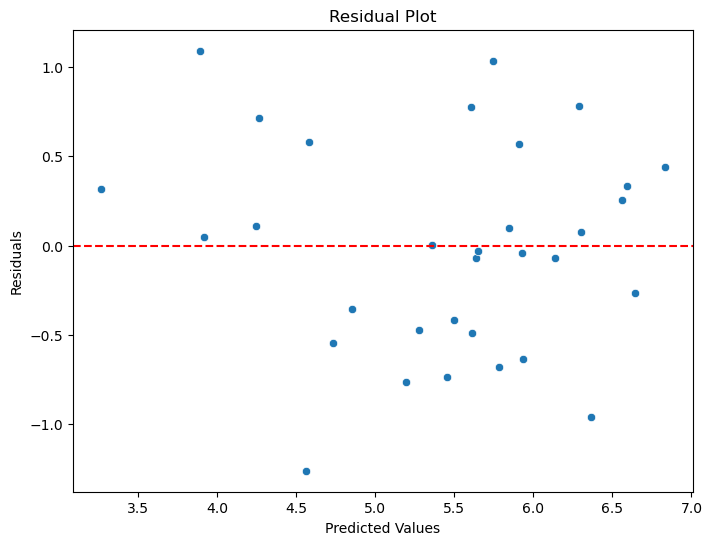

In [45]:
residuals = y_test - y_test_pred_simplified
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_pred_simplified, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


# Parsimonious Model

The most parsimonious model was determined based on:

AIC: Lower AIC indicates a better trade-off between goodness of fit and model complexity.

Test RMSE: Similar or better predictive performance compared to other models.

Feature Count: The simplified OLS model used fewer predictors while retaining predictive accuracy.

# Mixed Effects Model

The Mixed Effects Model accounted for variability at the group level ("Country or region"), which may provide more accurate predictions in hierarchical data structures. However, the added complexity may not justify its use if simpler models suffice.

# Conclusion

The OLS Simplified Model emerged as the most parsimonious model due to its:

Low AIC

Competitive Test RMSE

Reduced feature set.

The Mixed Effects Model offers insights into group-level variance but may not outperform simpler models in terms of parsimony.

# Appendix

Key Plots

Correlation Heatmap

Residual Plot

Boxplots of Key Predictors